In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter, FuncFormatter
import matplotlib as mpl
import pandas as pd
import re
%matplotlib inline

In [2]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = '1.0'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linewidth'] = '0.0'
plt.rcParams['grid.alpha'] = '0.18'
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['legend.labelspacing'] = 0.77
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{tipa}'

def format_log_labels(x, pos):
    if x >= 1:
        return f'{x:.0f}'
    elif x >= 0.1:
        return f'{x:.1f}'
    elif x >= 0.01:
        return f'{x:.2f}'
    else:
        return f'{x:.3f}'

In [3]:
experiments = {
    'week1': {
        'loader': 'hyperparameter',
        'experiments': [
            ('losses_original_lr1e3_bs256.txt', 'Original (LR=1e-3, BS=256)'),
            ('losses_lr1e4.txt', 'Lower LR (1e-4)'),
            ('losses_lr1e2.txt', 'Higher LR (1e-2)'),
            ('losses_bs128.txt', 'Smaller BS (128)')
        ]
    },
    
    'batch_size': {
        'loader': 'hyperparameter',
        'experiments': [
            ('losses_batch32.txt', 'Batch Size 32 | 250 epochs'),
            ('losses_bs128.txt', 'Batch Size 128 | 100 epochs'),
            ('losses_batch256.txt', 'Batch Size 256 | 250 epochs'),
            ('losses_batch1000.txt', 'Batch Size 1000 | 250 epochs'),
            ('losses_batch1000_500epochs.txt', 'Batch Size 1000 | 500 epochs')
        ]
    },
    
    'weight_decay': {
        'loader': 'hyperparameter',
        'experiments': [
            ('losses_wd_0.txt', 'Weight Decay 0'),
            ('losses_wd_1e1.txt', 'Weight Decay 1e-1'),
            ('losses_wd_1e3.txt', 'Weight Decay 1e-3'),
            ('losses_wd_1e5.txt', 'Weight Decay 1e-5')
        ]
    },
    
    'learning_rate': {
        'loader': 'hyperparameter',
        'experiments': [
            ('losses_lr1e2.txt', 'Learning Rate 1e-2'),
            ('losses_original_lr1e3_bs256.txt', 'Learning Rate 1e-3'),
            ('losses_lr1e4.txt', 'Learning Rate 1e-4'),
            ('losses_lr5e4.txt', 'Learning Rate 5e-4')
        ]
    },
    
    'extended_epochs': {
        'loader': 'hyperparameter',
        'experiments': [
            ('losses_extended_500.txt', '500 epochs'),
            ('losses_extended_600.txt', '600 epochs'),
            ('losses_extended_700.txt', '700 epochs'),
            ('losses_extended_800.txt', '800 epochs')
        ]
    },
    
    'accuracy': {
        'loader': 'hyperparameter',
        'experiments': [
            ('losses_original_lr1e3_bs256.txt', 'Low Accuracy (baseline)'),
            ('losses_high_accuracy.txt', 'High Accuracy'),
            ('losses_high_accuracy_400ep.txt', 'High Accuracy (400ep)'),
            ('losses_high_accuracy_bs32.txt', 'High Accuracy (BS=32)')
        ]
    },
    
    'combined': {
        'loader': 'hyperparameter',
        'experiments': [
            ('losses_bs32_wd0.txt', 'BS=32, WD=0'),
            ('losses_bs32_wd1e3.txt', 'BS=32, WD=1e-3'),
            ('losses_bs1000_wd1e3.txt', 'BS=1000, WD=1e-3'),
            ('losses_bs1000_wd1e5.txt', 'BS=1000, WD=1e-5')
        ]
    },
    
    'best': {
        'loader': 'hyperparameter',
        'experiments': [
            ('losses_best_combo1.txt', 'Best Combo 1 (BS=256, WD=1e-5)'),
            ('losses_best_combo2.txt', 'Best Combo 2 (BS=32, WD=0)'),
            ('losses_original_lr1e3_bs256.txt', 'Baseline')
        ]
    },
    
    'squeeze': {
        'loader': 'hyperparameter',
        'experiments': [
            ('losses_squeeze_2.txt', 'Squeeze factor = 2'),
            ('losses_squeeze_4.txt', 'Squeeze factor = 4'),
            ('losses_squeeze_8.txt', 'Squeeze factor = 8'),
            ('losses_squeeze_16.txt', 'Squeeze factor = 16'),
            ('losses_squeeze_32.txt', 'Squeeze factor = 32')
            # ('losses_temp8.txt', 'Squeeze factor = 8'),
        ]
    },
    
    'squeeze_comparison': {
        'loader': 'hyperparameter',
        'experiments': [
            ('losses_original_lr1e3_bs256.txt', 'Baseline (no squeeze)'),
            ('losses_squeeze_8.txt', 'Squeeze factor = 8'),
            ('losses_best_combo1.txt', 'Best combo (no squeeze)')
        ]
    },
    
    'transfer_learning': {
        'loader': 'transfer',
        'experiments': [
            ('losses_none.txt', 'Baseline (No Freezing)'),
            ('losses_early_1.txt', 'Early Freezing 1'),
            ('losses_early_2.txt', 'Early Freezing 2'),
            ('losses_early_3.txt', 'Early Freezing 3'),
            ('losses_early_4.txt', 'Early Freezing 4'),
            ('losses_late_1.txt', 'Late Freezing 1'),
            ('losses_late_2.txt', 'Late Freezing 2'),
            ('losses_late_3.txt', 'Late Freezing 3'),
            ('losses_late_4.txt', 'Late Freezing 4'),
            ('losses_input_output.txt', 'Input+Output'),
            ('losses_resnet_1.txt', 'ResNet Block 1'),
            ('losses_resnet_2.txt', 'ResNet Block 2'),
            ('losses_resnet_3.txt', 'ResNet Block 3'),
            ('losses_resnet_12.txt', 'ResNet Blocks 1+2'),
            # ('losses_resnet_13.txt', 'ResNet Blocks 1+3'),
            ('losses_resnet_23.txt', 'ResNet Blocks 2+3'),
            ('losses_resnet_123.txt', 'ResNet Blocks 1+2+3')
        ]
    },
    
    'transfer_learning_early': {
        'loader': 'transfer',
        'experiments': [
            ('losses_none.txt', 'Baseline (No Freezing)'),
            ('losses_early_1.txt', 'Early Freezing 1'),
            ('losses_early_2.txt', 'Early Freezing 2'),
            ('losses_early_3.txt', 'Early Freezing 3'),
            ('losses_early_4.txt', 'Early Freezing 4')
        ]
    },
    
    'transfer_learning_late': {
        'loader': 'transfer',
        'experiments': [
            ('losses_none.txt', 'Baseline (No Freezing)'),
            ('losses_late_1.txt', 'Late Freezing 1'),
            ('losses_late_2.txt', 'Late Freezing 2'),
            ('losses_late_3.txt', 'Late Freezing 3'),
            ('losses_late_4.txt', 'Late Freezing 4')
        ]
    },
    
    'transfer_learning_ResNet': {
        'loader': 'transfer',
        'experiments': [
            ('losses_none.txt', 'Baseline (No Freezing)'),
            ('losses_resnet_1.txt', 'ResNet Block 1'),
            ('losses_resnet_2.txt', 'ResNet Block 2'),
            ('losses_resnet_3.txt', 'ResNet Block 3'),
            ('losses_resnet_12.txt', 'ResNet Blocks 1+2'),
            # ('losses_resnet_13.txt', 'ResNet Blocks 1+3'),
            ('losses_resnet_23.txt', 'ResNet Blocks 2+3'),
            ('losses_resnet_123.txt', 'ResNet Blocks 1+2+3')
        ]
    },
    
    'transfer_learning_in_out': {
        'loader': 'transfer',
        'experiments': [
            ('losses_none.txt', 'Baseline (No Freezing)'),
            ('losses_input_output.txt', 'Input+Output')
        ]
    },
    
    'transfer_learning_comparison': {
        'loader': 'transfer',
        'experiments': [
            ('corrected_1k_validation/losses_high_acc_baseline.txt', 'Baseline'),
            ('corrected_1k_validation/losses_early_2.txt', 'Early Freezing 2'),
            ('corrected_1k_validation/losses_early_3.txt', 'Early Freezing 3'),
            ('corrected_1k_validation/losses_late_2.txt', 'Late Freezing 2'),
            ('corrected_1k_validation/losses_late_3.txt', 'Late Freezing 3'),
            ('corrected_1k_validation/losses_resnet_1.txt', 'ResNet Block 1'),
            ('corrected_1k_validation/losses_resnet_2.txt', 'ResNet Block 2'),
        ]
    }
}

In [4]:
def load_losses(filename, loader_type='hyperparameter'):
    """Load training and validation losses from losses.txt format
    
    Args:
        filename: Name of the file to load
        loader_type: Either 'hyperparameter' or 'transfer' to specify directory
        
    Returns: train_losses, val_losses
    """
    # Set filepath based on loader type
    if loader_type == 'hyperparameter':
        filepath = f'projects/lsst_y1/hyperparameter_results/losses/{filename}'
    elif loader_type == 'transfer':
        filepath = f'projects/lsst_y1/transfer_learning_testing_1000epochs/{filename}' # _1000epochs
    else:
        raise ValueError(f"Unknown loader_type: {loader_type}. Use 'hyperparameter' or 'transfer'")
    
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()
        
        # Parse training losses (first row)
        train_losses = np.array([float(x) for x in lines[0].strip().split()])
        # Parse validation losses (second row)  
        val_losses = np.array([float(x) for x in lines[1].strip().split()])
        
        return train_losses, val_losses
    except FileNotFoundError:
        print(f"File {filepath} not found")
        return None, None

# Load experiment for plotting

In [5]:
# Function to get colors from a colormap
def get_colors_from_cmap(cmap_name, n_colors):
    """Get n_colors from a matplotlib colormap"""
    cmap = mpl.colormaps[cmap_name]
    return [cmap(i / (n_colors - 1)) for i in range(n_colors)]

# Choose which experiment group to load
experiment_group = 'transfer_learning_comparison'

# Get experiment info
experiment_info = experiments[experiment_group]
experiment_list = experiment_info['experiments']
loader_type = experiment_info['loader']

# Generate colors from colormap
colors = get_colors_from_cmap('inferno', len(experiment_list)+2)

# Load loss data
loss_data = {}
for i, (filename, label) in enumerate(experiment_list):
    train_losses, val_losses = load_losses(filename, loader_type=loader_type)
    if train_losses is not None:
        loss_data[label] = {
            'train': train_losses, 
            'val': val_losses,
            'color': colors[1+i]
        }
        print(f"Loaded {label}: {len(train_losses)} epochs")
    else:
        print(f"Could not load {label}")

print(f"\nLoaded {len(loss_data)} experiments from {experiment_group} using {loader_type} loader")

Loaded Baseline: 1000 epochs
Loaded Early Freezing 2: 1000 epochs
Loaded Early Freezing 3: 1000 epochs
Loaded Late Freezing 2: 1000 epochs
Loaded Late Freezing 3: 1000 epochs
Loaded ResNet Block 1: 1000 epochs
Loaded ResNet Block 2: 1000 epochs

Loaded 7 experiments from transfer_learning_comparison using transfer loader


# Plotting

In [ ]:
def plot_transfer_learning_comparison(loss_data, experiment_group, save_name=None):
    """Create comprehensive transfer learning comparison plots"""
    
    if save_name is None:
        save_name = f'transfer_learning_comparison_{experiment_group}'
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 15))
    
    # Plot 1: Training losses
    for label, data in loss_data.items():
        epochs = range(1, len(data['train']) + 1)
        ax1.plot(epochs, data['train'], label=label, color=data['color'], linewidth=2.5, alpha=0.75)
    
    ax1.set_xlabel('Epoch', fontsize=20)
    ax1.set_ylabel('Training Loss', fontsize=20)
    ax1.set_title('Training Loss by Transfer Learning Strategy', fontweight='bold', fontsize=22)
    ax1.set_yscale('log')
    ax1.set_ylim(0.19, 1)
    ax1.grid(True, alpha=0.5)
    ax1.tick_params(labelsize=16)
    
    # Plot 2: Validation losses  
    for label, data in loss_data.items():
        epochs = range(1, len(data['val']) + 1)
        ax2.plot(epochs, data['val'], label=label, color=data['color'], linewidth=2.5, alpha=0.75)
    
    ax2.set_xlabel('Epoch', fontsize=20)
    ax2.set_ylabel('Validation Loss', fontsize=20)
    ax2.set_title('Validation Loss by Transfer Learning Strategy', fontweight='bold', fontsize=22)
    ax2.set_yscale('log')
    ax2.set_ylim(0.1, 1)
    ax2.grid(True, alpha=0.5)
    ax2.tick_params(labelsize=16)
    ax2.legend(fontsize=14, framealpha=0.9)
    
    # Plot 3: Final performance comparison
    labels = list(loss_data.keys())
    final_train = [loss_data[label]['train'][-1] for label in labels]
    final_val = [loss_data[label]['val'][-1] for label in labels]
    colors = [loss_data[label]['color'] for label in labels]
    
    x = np.arange(len(labels))
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, final_train, width, label='Training', color=colors, alpha=0.7)
    bars2 = ax3.bar(x + width/2, final_val, width, label='Validation', color=colors, alpha=1.0, edgecolor='black', linewidth=0.5)
    
    ax3.set_xlabel('Strategy', fontsize=20)
    ax3.set_ylabel('Final Loss', fontsize=20)
    ax3.set_title('Final Performance Comparison', fontweight='bold', fontsize=22)
    ax3.set_yscale('log')
    ax3.set_ylim(0.05, 0.5)    
    ax3.set_xticks(x)
    ax3.set_xticklabels(labels, rotation=45, ha='right', fontsize=14)
    ax3.tick_params(axis='y', labelsize=16)
    ax3.legend(fontsize=16)
    
    # Plot 4: Convergence speed analysis
    convergence_epochs = []
    for label in labels:
        data = loss_data[label]
        final_loss = data['val'][-1]
        target = final_loss * 1.1  # 10% above final
        converged_epoch = next((i for i, loss in enumerate(data['val']) if loss <= target), len(data['val']))
        convergence_epochs.append(converged_epoch)
    
    bars3 = ax4.bar(labels, convergence_epochs, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax4.set_xlabel('Strategy', fontsize=20)
    ax4.set_ylabel('Epochs to Convergence', fontsize=20)
    ax4.set_title('Convergence Speed Comparison', fontweight='bold', fontsize=22)
    ax4.set_ylim(0, max(convergence_epochs) * 1.1)
    ax4.set_xticks(range(len(labels)))
    ax4.set_xticklabels(labels, rotation=45, ha='right', fontsize=14)
    ax4.tick_params(axis='y', labelsize=16)
    
    # Add value labels on convergence bars
    for bar, val in zip(bars3, convergence_epochs):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                str(val), ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.suptitle('Transfer Learning Strategy Comparison - Cosmic Shear Emulation', 
                 fontsize=24, fontweight='bold')
    plt.tight_layout()
    # plt.savefig(f'{save_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

fig = plot_transfer_learning_comparison(loss_data, experiment_group)

In [6]:
plt.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 30,
    'axes.titlesize': 34,
    'xtick.labelsize': 26,
    'ytick.labelsize': 26,
    'legend.fontsize': 20,
    'figure.titlesize': 30
})

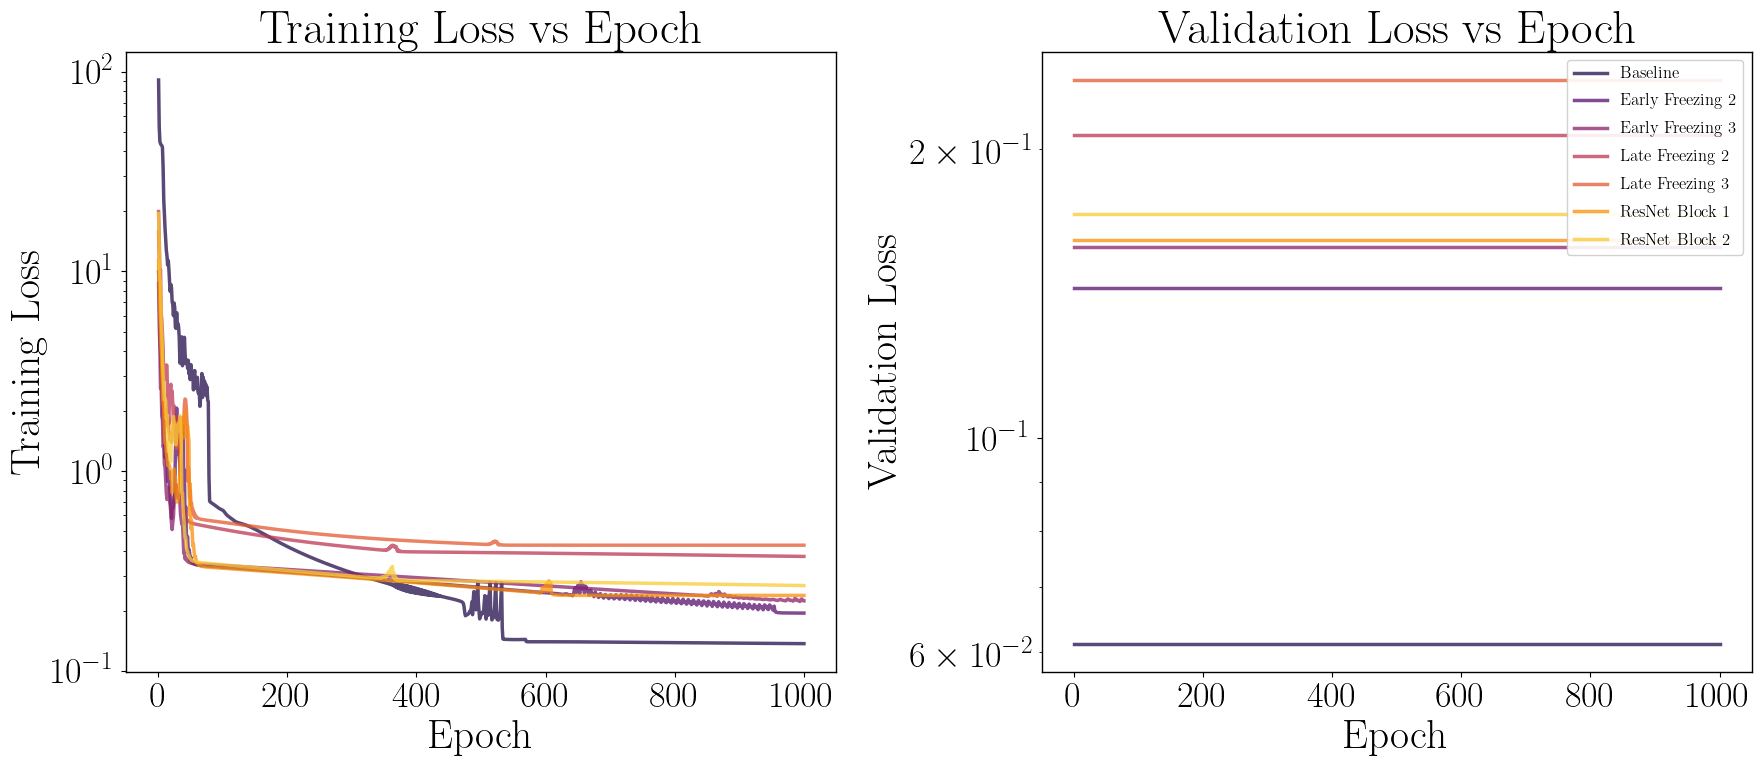

In [9]:
# Create comparison plots with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot all experiments
for label, data in loss_data.items():
    epochs = range(1, len(data['train']) + 1)
    
    # Training loss
    ax1.plot(epochs, data['train'], color=data['color'], label=label, linewidth=2.5, alpha=0.75)
    
    # Validation loss
    ax2.plot(epochs, data['val'], color=data['color'], label=label, linewidth=2.5, alpha=0.75)
    
handles, labels = ax2.get_legend_handles_labels()

# Format training loss plot
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss vs Epoch')
ax1.set_yscale('log')
#ax1.set_ylim(0.19, 1)
ax1.grid(True, alpha=0.5)

# Format validation loss plot
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Loss')
ax2.set_title('Validation Loss vs Epoch')
ax2.set_yscale('log')
#ax2.set_ylim(0.1, 1)
ax2.legend(handles, labels, loc='upper right', framealpha=0.9, fontsize=12)
ax2.grid(True, alpha=0.5)

plt.tight_layout()
# plt.savefig(f'combined_losses_{experiment_group}.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Create comparison plots with 2 subplots (bar charts only)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

# Plot 1: Final performance comparison
labels = list(loss_data.keys())
final_train = [loss_data[label]['train'][-1] for label in labels]
final_val = [loss_data[label]['val'][-1] for label in labels]
colors = [loss_data[label]['color'] for label in labels]

x = np.arange(len(labels))
width = 0.35

bars1 = ax1.bar(x - width/2, final_train, width, label='Training', color=colors, alpha=0.7)
bars2 = ax1.bar(x + width/2, final_val, width, label='Validation', color=colors, alpha=1.0, edgecolor='black', linewidth=0.5)

ax1.set_ylabel('Final Loss')
ax1.set_title('Final Performance Comparison', fontweight='bold')
ax1.set_yscale('log')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.tick_params(direction='out', length=6, width=1.5, which='both')
ax1.yaxis.set_major_formatter(FuncFormatter(format_log_labels))
ax1.yaxis.set_minor_formatter(FuncFormatter(format_log_labels)) 
ax1.legend(fontsize=16)

# Plot 2: Convergence speed analysis
convergence_epochs = []
for label in labels:
    data = loss_data[label]
    final_loss = data['val'][-1]
    target = final_loss * 1.1  # 10% above final
    converged_epoch = next((i for i, loss in enumerate(data['val']) if loss <= target), len(data['val']))
    convergence_epochs.append(converged_epoch)

bars3 = ax2.bar(labels, convergence_epochs, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax2.set_ylabel('Epochs to Convergence')
ax2.set_title('Convergence Speed Comparison', fontweight='bold')
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.tick_params(direction='out', length=6, width=1.5, which='both')

# Add value labels on convergence bars
for bar, val in zip(bars3, convergence_epochs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,  
             str(val), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.suptitle('Transfer Learning Strategy Comparison - Cosmic Shear Emulation', 
             fontsize=24, fontweight='bold')
plt.tight_layout()
# plt.savefig(f'combined_comparison_{experiment_group}.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2594963/3600223717.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipykernel_2594963/3600223717.py:48: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


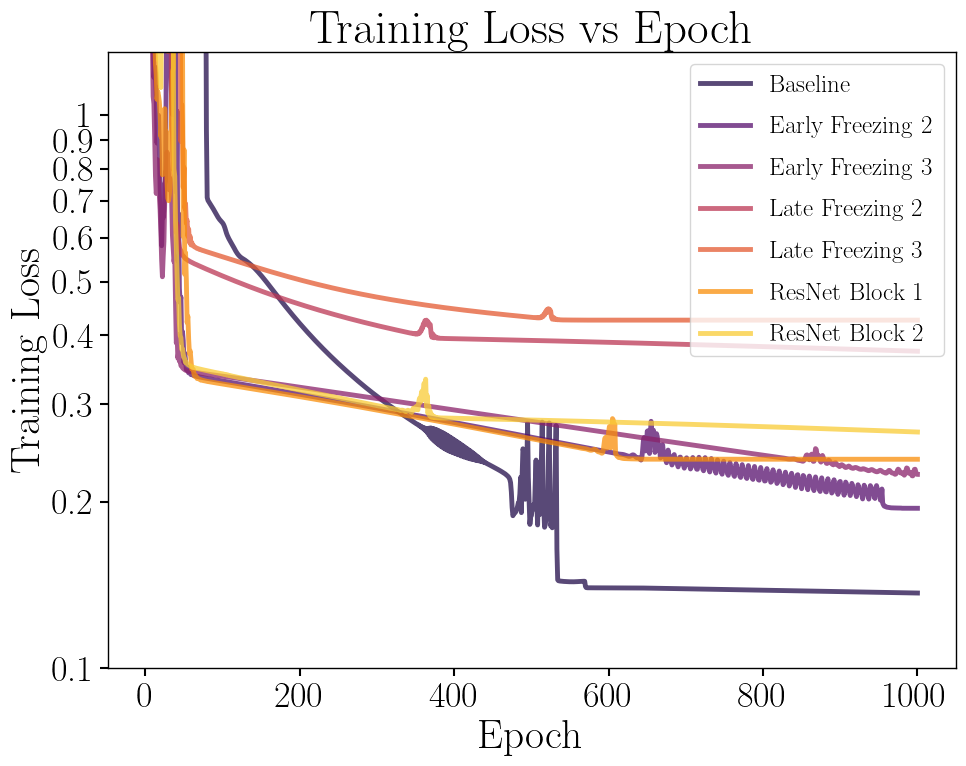

In [36]:
# Figure 1: Training Loss
fig1, ax1 = plt.subplots(figsize=(10, 8))
for label, data in loss_data.items():
    epochs = range(1, len(data['train']) + 1)
    ax1.plot(epochs, data['train'], color=data['color'], label=label, 
             linewidth=3.5, alpha=0.75)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss vs Epoch')
ax1.set_yscale('log')
ax1.set_ylim(0.1, 1.3)
ax1.grid(True, alpha=0.5)
ax1.tick_params(direction='out', length=6, width=1.5, which='both')
ax1.yaxis.set_major_locator(plt.FixedLocator([0.1, 0.2, 0.3, 0.5, 1]))
ax1.yaxis.set_major_formatter(FuncFormatter(format_log_labels))
ax1.yaxis.set_minor_formatter(FuncFormatter(format_log_labels)) 
ax1.legend(loc='best', framealpha=0.8, fontsize=18)
plt.tight_layout()
plt.savefig(f'train_loss_comparison.png', dpi=300, bbox_inches='tight') #_{experiment_group}
plt.show()

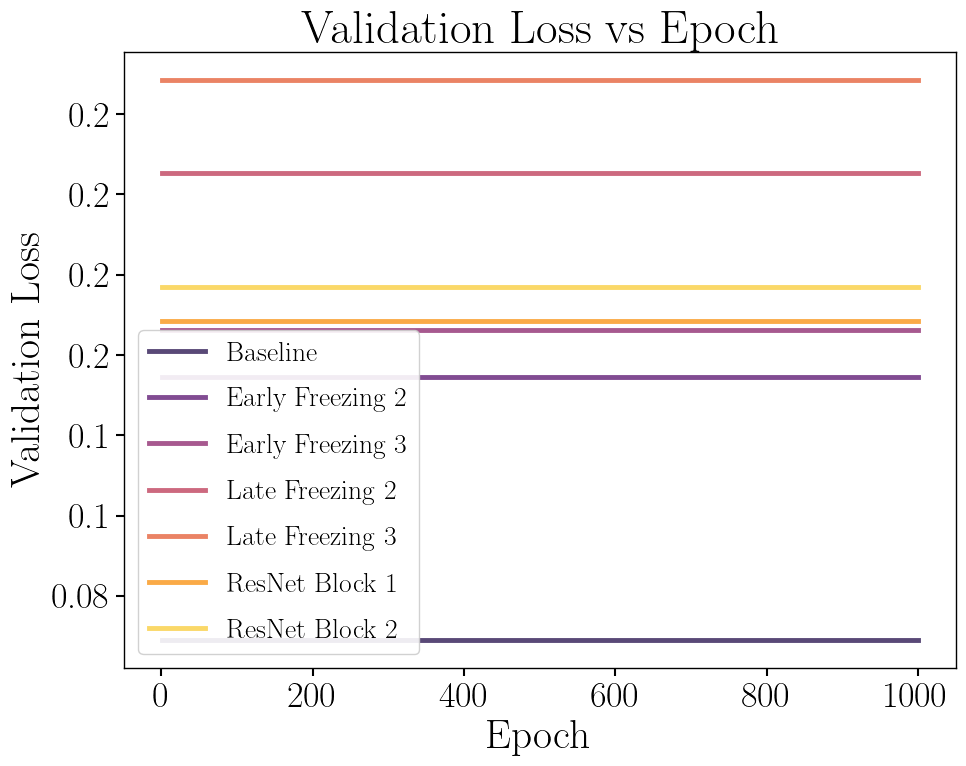

In [13]:
# Figure 2: Validation Loss
fig2, ax2 = plt.subplots(figsize=(10, 8))
for label, data in loss_data.items():
    epochs = range(1, len(data['val']) + 1)
    ax2.plot(epochs, data['val'], color=data['color'], label=label, 
             linewidth=3.5, alpha=0.75)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Loss')
ax2.set_title('Validation Loss vs Epoch')
#ax2.set_yscale('log')
# ax2.set_ylim(0.1, 1)
ax2.grid(True, alpha=0.5)
ax2.tick_params(direction='out', length=6, width=1.5, which='both')
ax2.yaxis.set_major_formatter(FuncFormatter(format_log_labels))
ax2.yaxis.set_minor_formatter(FuncFormatter(format_log_labels)) 
ax2.legend(loc='best', framealpha=0.9)
plt.tight_layout()
# plt.savefig(f'val_loss_{experiment_group}.png', dpi=300, bbox_inches='tight')
plt.show()

# Money Plot

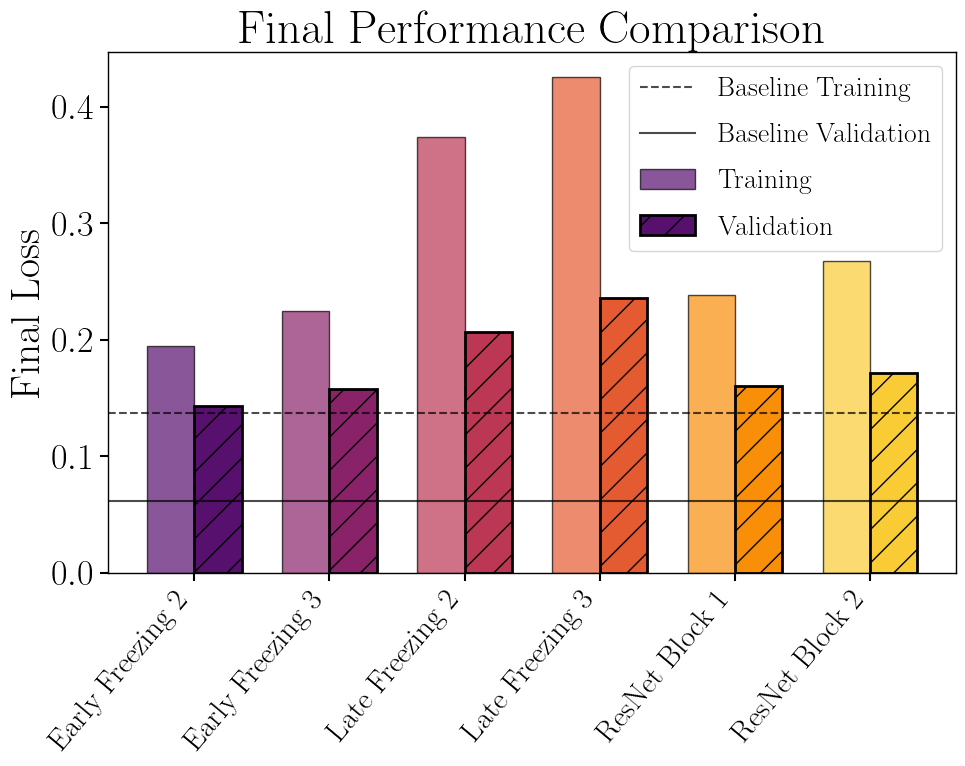

In [14]:
# Individual plot: Final Performance Comparison
fig3, ax3 = plt.subplots(figsize=(10, 8))

labels = list(loss_data.keys())
baseline_label = 'Baseline'  # Adjust to match your actual baseline name

other_labels = [l for l in labels if l != baseline_label]
baseline_train = loss_data[baseline_label]['train'][-1] if baseline_label in labels else None
baseline_val = loss_data[baseline_label]['val'][-1] if baseline_label in labels else None

final_train = [loss_data[label]['train'][-1] for label in other_labels]
final_val = [loss_data[label]['val'][-1] for label in other_labels]
colors = [loss_data[label]['color'] for label in other_labels]

x = np.arange(len(other_labels))
width = 0.35

bars1 = ax3.bar(x - width/2, final_train, width, label='Training', color=colors, alpha=0.7, 
        edgecolor='black', linewidth=1) 
bars2 = ax3.bar(x + width/2, final_val, width, label='Validation', color=colors, alpha=1.0,
        edgecolor='black', linewidth=2, hatch='/') 

if baseline_train is not None:
    ax3.axhline(y=baseline_train, color='black', linestyle='--', linewidth=1.5, alpha=0.7, label='Baseline Training')
if baseline_val is not None:
    ax3.axhline(y=baseline_val, color='black', linestyle='-', linewidth=1.5, alpha=0.7, label='Baseline Validation')

ax3.set_ylabel('Final Loss')
ax3.set_title('Final Performance Comparison')
# ax3.set_ylim(0, 0.5)
# ax3.yaxis.set_major_locator(plt.FixedLocator([0, 0.1, 0.2, 0.3, 0.4, 0.5]))
ax3.set_xticks(x)
ax3.tick_params(direction='out', length=6, width=1.5, which='both')
ax3.set_xticklabels(other_labels, rotation=50, ha='right', fontsize=22) 
ax3.legend()
plt.tight_layout()
# plt.savefig(f'final_performance_{experiment_group}.pdf', format="pdf", bbox_inches="tight", dpi=300, pad_inches=0.05)
plt.show()

/tmp/ipykernel_2594963/3856885683.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(labels, rotation=45, ha='right')


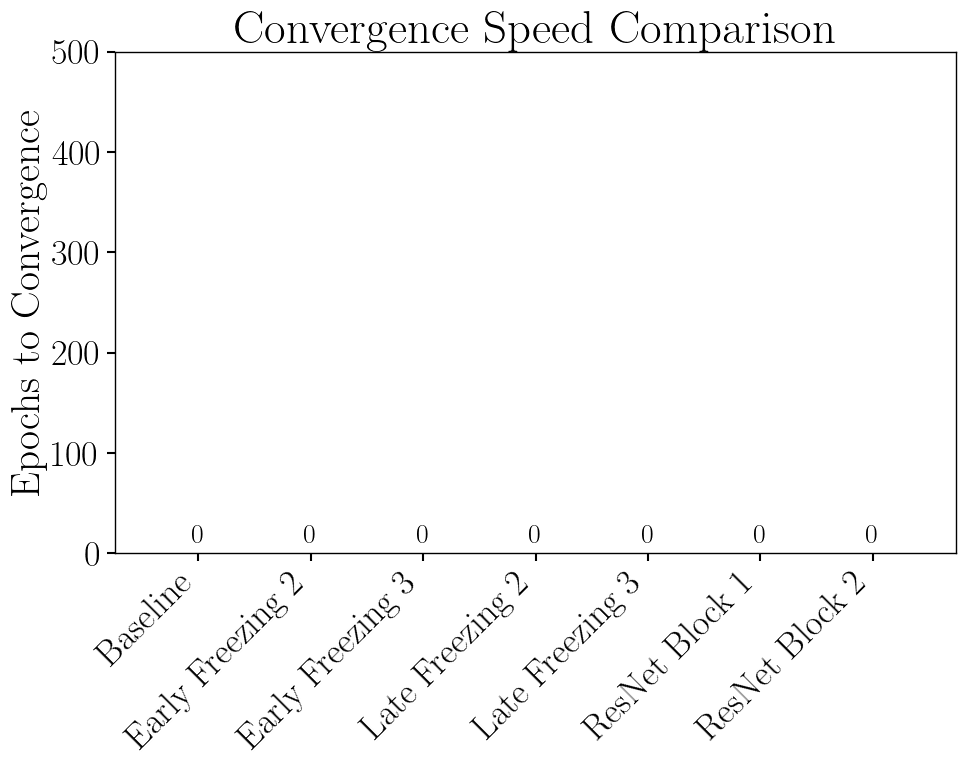

In [15]:
# Individual plot: Convergence Speed
fig4, ax4 = plt.subplots(figsize=(10, 8))

labels = list(loss_data.keys())
colors = [loss_data[label]['color'] for label in labels]

convergence_epochs = []
for label in labels:
    data = loss_data[label]
    final_loss = data['val'][-1]
    target = final_loss * 1.1  # 10% above final
    converged_epoch = next((i for i, loss in enumerate(data['val']) if loss <= target), len(data['val']))
    convergence_epochs.append(converged_epoch)

bars = ax4.bar(labels, convergence_epochs, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax4.set_ylabel('Epochs to Convergence')
ax4.set_title('Convergence Speed Comparison')
ax4.set_ylim(0, 500)
ax4.tick_params(direction='out', length=6, width=1.5, which='both')
ax4.set_xticklabels(labels, rotation=45, ha='right')

# Add value labels on bars
for bar, val in zip(bars, convergence_epochs):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            str(val), ha='center', va='bottom', fontsize=20, fontweight='bold')

plt.tight_layout()
# plt.savefig(f'convergence_speed_{experiment_group}.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
def analyze_transfer_learning_results(loss_data):
    """Generate ranking and key insights"""
    
    # Create performance ranking
    results = []
    for label, data in loss_data.items():
        final_train = data['train'][-1]
        final_val = data['val'][-1]
        improvement_ratio = data['val'][0] / final_val  # How much better than start
        
        results.append({
            'Strategy': label,
            'Final Training Loss': f"{final_train:.3e}",
            'Final Validation Loss': f"{final_val:.3e}",
            'Improvement Ratio': f"{improvement_ratio:.1f}x",
            'Val Loss (numeric)': final_val
        })
    
    # Sort by validation loss
    results.sort(key=lambda x: x['Val Loss (numeric)'])
    
    print("="*100)
    print("TRANSFER LEARNING STRATEGY RANKING")
    print("="*100)
    for i, result in enumerate(results, 1):
        print(f"{i:2d}. {result['Strategy']:<30} | Val Loss: {result['Final Validation Loss']:<12} | Improvement: {result['Improvement Ratio']}")
    
    print(f"\nBEST STRATEGY: {results[0]['Strategy']}")
    print(f"SECOND BEST: {results[1]['Strategy']}")
    print(f"WORST STRATEGY: {results[-1]['Strategy']}")
    
    # Category analysis
    resnet_strategies = [r for r in results if 'ResNet' in r['Strategy']]
    other_strategies = [r for r in results if 'ResNet' not in r['Strategy']]
    
    if resnet_strategies and other_strategies:
        resnet_avg = np.mean([r['Val Loss (numeric)'] for r in resnet_strategies])
        other_avg = np.mean([r['Val Loss (numeric)'] for r in other_strategies])
        improvement = ((other_avg - resnet_avg) / other_avg) * 100
        
        print(f"\nRESNET BLOCK ANALYSIS:")
        print(f"   ResNet strategies average: {resnet_avg:.3e}")
        print(f"   Other strategies average: {other_avg:.3e}")
        print(f"   ResNet improvement: {improvement:.1f}%")
    
    return results

# Generate ranking and insights
ranking = analyze_transfer_learning_results(loss_data)

TRANSFER LEARNING STRATEGY RANKING
 1. Baseline                       | Val Loss: 6.115e-02    | Improvement: 1.0x
 2. Early Freezing 2               | Val Loss: 1.432e-01    | Improvement: 1.0x
 3. Early Freezing 3               | Val Loss: 1.579e-01    | Improvement: 1.0x
 4. ResNet Block 1                 | Val Loss: 1.605e-01    | Improvement: 1.0x
 5. ResNet Block 2                 | Val Loss: 1.710e-01    | Improvement: 1.0x
 6. Late Freezing 2                | Val Loss: 2.066e-01    | Improvement: 1.0x
 7. Late Freezing 3                | Val Loss: 2.357e-01    | Improvement: 1.0x

BEST STRATEGY: Baseline
SECOND BEST: Early Freezing 2
WORST STRATEGY: Late Freezing 3

RESNET BLOCK ANALYSIS:
   ResNet strategies average: 1.658e-01
   Other strategies average: 1.609e-01
   ResNet improvement: -3.0%


# Compare learning rate drops # NOT WORKING

In [ ]:
# import pandas as pd

# # Simple results summary
# results = []
# for label, data in loss_data.items():
#     results.append({
#         'Experiment': label,
#         'Final Train Loss': f"{data['train'][-1]:.4f}",
#         'Final Val Loss': f"{data['val'][-1]:.4f}",
#         'Epochs': len(data['train'])
#     })

# df = pd.DataFrame(results)
# # Sort by final validation loss
# df = df.sort_values('Final Val Loss')
# print(df.to_string(index=False))

In [ ]:
# def plot_learning_rate_schedule(log_file='transfer_learning_testing.log'):
#     """Simple LR schedule plot for current experiment group"""
#     import re
    
#     # Use the already-loaded loss_data keys instead of experiments dict
#     experiment_labels = {label: {'epochs': [], 'lrs': []} for label in loss_data.keys()}
    
#     current_exp = None
    
#     with open(log_file, 'r') as f:
#         for line in f:
#             # Check if we're starting a new experiment
#             for label in experiment_labels.keys():
#                 if label in line:
#                     current_exp = label
#                     break
            
#             # Parse LR from epoch lines
#             if current_exp and 'Epoch' in line and 'lr=' in line:
#                 epoch_match = re.search(r'Epoch\s+(\d+)/', line)
#                 lr_match = re.search(r'lr=([0-9.e+-]+)', line)
                
#                 if epoch_match and lr_match:
#                     epoch = int(epoch_match.group(1))
#                     lr = float(lr_match.group(1))
                    
#                     # Only store if LR changed
#                     if len(experiment_labels[current_exp]['lrs']) == 0 or lr != experiment_labels[current_exp]['lrs'][-1]:
#                         experiment_labels[current_exp]['epochs'].append(epoch)
#                         experiment_labels[current_exp]['lrs'].append(lr)
    
#     # Plot
#     plt.figure(figsize=(10, 6))
#     for label in experiment_labels:
#         if len(experiment_labels[label]['epochs']) > 0:
#             color = loss_data[label]['color']
#             plt.step(experiment_labels[label]['epochs'], 
#                     experiment_labels[label]['lrs'],
#                     color=color, label=label, linewidth=2.5, alpha=0.8, where='post')
    
#     plt.xlabel('Epoch', fontsize=20)
#     plt.ylabel('Learning Rate', fontsize=20)
#     plt.title('Learning Rate Schedule', fontsize=22, fontweight='bold')
#     plt.yscale('log')
#     plt.grid(True, alpha=0.3)
#     plt.xlim(0, 500)
#     plt.tick_params(labelsize=16)
#     plt.legend(fontsize=14, framealpha=0.9)
#     plt.tight_layout()
#     plt.savefig(f'lr_schedule_{experiment_group}.png', dpi=300, bbox_inches='tight')
#     plt.show()

# plot_learning_rate_schedule('transfer_learning_testing.log')

In [ ]:
# import pandas as pd

# results = []
# for label, data in loss_data.items():
#     results.append({
#         'Experiment': label,
#         'Final Train Loss': f"{data['train'][-1]:.4f}",
#         'Final Val Loss': f"{data['val'][-1]:.4f}",
#         'Epochs': len(data['train'])
#     })

# df = pd.DataFrame(results)
# print(df.to_string(index=False))

In [ ]:
# import re

# def parse_learning_rates_from_log(log_file_path='overnight.log'):
#     """
#     Parse learning rates and epochs from the overnight log file.
#     Returns a dictionary of experiments with their LR vs epoch data.
#     """
    
#     experiments = {}
#     current_experiment = None
    
#     with open(log_file_path, 'r') as f:
#         lines = f.readlines()
    
#     # Track which experiment we're currently parsing
#     experiment_patterns = {
#         'extended_500': 'Running.*500 epochs',
#         'extended_600': 'Running.*600 epochs', 
#         'extended_700': 'Running.*700 epochs',
#         'extended_800': 'Running.*800 epochs'
#     }
    
#     for line in lines:
#         # Check if we're starting a new experiment
#         for exp_name, pattern in experiment_patterns.items():
#             if re.search(pattern, line, re.IGNORECASE):
#                 current_experiment = exp_name
#                 experiments[exp_name] = {'epochs': [], 'learning_rates': []}
#                 break
        
#         # Parse epoch lines: look for pattern like "Epoch 123/500 | ... | lr=1.00e-05 |"
#         if current_experiment and 'Epoch' in line and 'lr=' in line:
#             # Extract epoch number and learning rate
#             epoch_match = re.search(r'Epoch\s+(\d+)/(\d+)', line)
#             lr_match = re.search(r'lr=([0-9]+\.?[0-9]*e?[+-]?[0-9]*)', line)
            
#             if epoch_match and lr_match:
#                 epoch = int(epoch_match.group(1))
#                 total_epochs = int(epoch_match.group(2))
#                 lr = float(lr_match.group(1))
                
#                 # Verify this matches the expected experiment
#                 expected_epochs = int(current_experiment.split('_')[1])
#                 if total_epochs == expected_epochs:
#                     experiments[current_experiment]['epochs'].append(epoch)
#                     experiments[current_experiment]['learning_rates'].append(lr)
    
#     # Convert to numpy arrays
#     for exp_name in experiments:
#         experiments[exp_name]['epochs'] = np.array(experiments[exp_name]['epochs'])
#         experiments[exp_name]['learning_rates'] = np.array(experiments[exp_name]['learning_rates'])
    
#     return experiments

# def plot_learning_rate_schedules(experiments):
#     """
#     Plot learning rate vs epoch for extended training experiments
#     """
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
#     colors = {'extended_500': 'blue', 'extended_600': 'green', 
#               'extended_700': 'orange', 'extended_800': 'red'}
    
#     for exp_name, data in experiments.items():
#         if len(data['epochs']) == 0:
#             print(f"No data found for {exp_name}")
#             continue
            
#         label = f"{exp_name.replace('extended_', '')} epochs"
#         color = colors.get(exp_name, 'black')
        
#         # Plot 1: Learning rate schedule
#         ax1.plot(data['epochs'], data['learning_rates'], 
#                 color=color, label=label, linewidth=2, marker='o', markersize=1)
    
#     ax1.set_xlabel('Epoch')
#     ax1.set_ylabel('Learning Rate')
#     ax1.set_title('Learning Rate Schedule vs Epoch')
#     ax1.set_yscale('log')
#     ax1.grid(True, alpha=0.3)
#     ax1.legend()
    
#     # Plot 2: Learning rate drops (step function view)
#     for exp_name, data in experiments.items():
#         if len(data['epochs']) == 0:
#             continue
            
#         label = f"{exp_name.replace('extended_', '')} epochs"
#         color = colors.get(exp_name, 'black')
        
#         # Create step plot to show LR drops clearly
#         ax2.step(data['epochs'], data['learning_rates'], 
#                 color=color, label=label, linewidth=2, where='post')
    
#     ax2.set_xlabel('Epoch')
#     ax2.set_ylabel('Learning Rate') 
#     ax2.set_title('Learning Rate Drops (Step View)')
#     ax2.set_yscale('log')
#     ax2.grid(True, alpha=0.3)
#     ax2.legend()
    
#     # Add horizontal lines for target learning rates
#     for ax in [ax1, ax2]:
#         ax.axhline(y=1e-6, color='gray', linestyle='--', alpha=0.5, label='Target: 1e-6')
#         ax.axhline(y=1e-7, color='gray', linestyle=':', alpha=0.5, label='Target: 1e-7')
    
#     plt.tight_layout()
#     plt.savefig('learning_rate_schedules.png', dpi=300, bbox_inches='tight')
#     plt.show()
    
#     return fig

# def analyze_lr_progression(experiments):
#     """
#     Print analysis of learning rate progression
#     """
#     print("Learning Rate Analysis:")
#     print("-" * 50)
    
#     for exp_name, data in experiments.items():
#         if len(data['epochs']) == 0:
#             continue
            
#         epochs = data['epochs']
#         lrs = data['learning_rates']
        
#         # Find LR drops
#         lr_drops = []
#         for i in range(1, len(lrs)):
#             if lrs[i] < lrs[i-1]:
#                 lr_drops.append((epochs[i], lrs[i-1], lrs[i]))
        
#         print(f"\n{exp_name.replace('extended_', '')} epochs:")
#         print(f"  Started at: {lrs[0]:.0e}")
#         print(f"  Ended at: {lrs[-1]:.0e}")
#         print(f"  Number of LR drops: {len(lr_drops)}")
        
#         for i, (epoch, old_lr, new_lr) in enumerate(lr_drops):
#             reduction_factor = old_lr / new_lr
#             print(f"    Drop {i+1}: Epoch {epoch}, {old_lr:.0e} → {new_lr:.0e} ({reduction_factor:.1f}x reduction)")
        
#         # Check if reached targets
#         min_lr = min(lrs)
#         reached_1e6 = min_lr <= 1e-6
#         reached_1e7 = min_lr <= 1e-7
        
#         print(f"  Reached 1e-6: {'✓' if reached_1e6 else '✗'}")
#         print(f"  Reached 1e-7: {'✓' if reached_1e7 else '✗'}")

# # Usage in your notebook:
# if __name__ == "__main__":
#     # Parse the log file
#     experiments = parse_learning_rates_from_log('overnight.log')
    
#     # Create plots
#     plot_learning_rate_schedules(experiments)
    
#     # Print analysis
#     analyze_lr_progression(experiments)